<a href="https://colab.research.google.com/github/vivek-varma/Volatality_Prediction_ML/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip -q install lightgbm

import os, json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from google.colab import drive
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

In [2]:
drive.mount('/content/drive', force_remount=False)
DATA_DIR = "/content/drive/MyDrive/Regime_pred/Data"
OUT_DIR  = "/content/drive/MyDrive/Regime_pred/Models/LightGBM_Tuned"
os.makedirs(OUT_DIR, exist_ok=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv(f"{DATA_DIR}/REGIME_FEATURES_DAILY_LABELED.csv", parse_dates=["date"]).sort_values("date").reset_index(drop=True)
print("Rows:", len(df), "| Date range:", df.date.min().date(), "→", df.date.max().date())
print("Class counts:", df["regime_y"].value_counts().to_dict())

Rows: 3478 | Date range: 2018-01-08 → 2024-12-31
Class counts: {2: 1182, 0: 1148, 1: 1148}


In [4]:
drop_cols = ["date", "regime_y", "RV_t1"]  # drop ID/leak columns
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
y = df["regime_y"].astype(int)

In [5]:
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X[c] = X[c].astype("category")

In [6]:
n = len(df)
n_train = int(math.floor(n * 0.60))
n_val   = int(math.floor(n * 0.20))
train_idx = np.arange(0, n_train)
val_idx   = np.arange(n_train, n_train + n_val)
test_idx  = np.arange(n_train + n_val, n)

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val,   y_val   = X.iloc[val_idx],   y.iloc[val_idx]
X_test,  y_test  = X.iloc[test_idx],  y.iloc[test_idx]

dates_val  = df.iloc[val_idx]["date"].dt.date.values
dates_test = df.iloc[test_idx]["date"].dt.date.values

In [7]:
print(f"Train {len(X_train)}  Val {len(X_val)}  Test {len(X_test)}")
print(f"Val period : {df.iloc[val_idx[0]].date.date()} → {df.iloc[val_idx[-1]].date.date()}")
print(f"Test period: {df.iloc[test_idx[0]].date.date()} → {df.iloc[test_idx[-1]].date.date()}")


Train 2086  Val 695  Test 697
Val period : 2022-03-16 → 2023-08-07
Test period: 2023-08-08 → 2024-12-31


In [8]:
print(X_train.head())

         RV   ret_std  nobs level_1        ret      RV_5     RV_10     RV_21  \
0  0.000007  0.000138   391   rkurt   3.583200  0.000015  0.000013  0.000013   
1  0.000016  0.000205   391   rskew   1.462809  0.000014  0.000014  0.000013   
2  0.000016  0.000205   391   rkurt  16.556561  0.000014  0.000014  0.000014   
3  0.000029  0.000271   391   rkurt  82.266350  0.000015  0.000016  0.000015   
4  0.000029  0.000271   391   rskew  -6.147298  0.000020  0.000018  0.000016   

     VOV_21  RV_chg_1  ...  vix3m  vix6m   vvix   S_short    S_long      CURV  \
0  0.000005  0.000000  ...  12.15  14.21  93.97  0.276260  0.169547 -0.059874   
1  0.000005  1.206724  ...  12.41  14.32  94.74  0.231151  0.153908 -0.041667   
2  0.000005  0.000000  ...  12.41  14.32  94.74  0.231151  0.153908 -0.041667   
3  0.000006  0.755095  ...  12.36  14.31  93.70  0.258656  0.157767 -0.060081   
4  0.000007  0.000000  ...  12.36  14.31  93.70  0.258656  0.157767 -0.060081   

       VRP_21  vix_to_vix3m  vix

In [14]:
classes = np.sort(y_train.unique())
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_map = {int(c): w for c, w in zip(classes, weights)}
w_train = y_train.map(class_weight_map).values

# ---- Random search space (compact but effective) ----
rng = np.random.default_rng(1337)
def sample_params():
    return dict(
        n_estimators=int(rng.integers(600, 1600)),
        learning_rate=float(rng.uniform(0.01, 0.07)),
        num_leaves=int(rng.integers(15, 63)),
        max_depth=int(rng.integers(3, 9)),              # -1 lets num_leaves dominate; here we bound it for stability
        subsample=float(rng.uniform(0.7, 1.0)),         # bagging_fraction
        colsample_bytree=float(rng.uniform(0.7, 1.0)),  # feature_fraction
        min_child_samples=int(rng.integers(10, 120)),
        reg_alpha=float(10**rng.uniform(-3, 1)),        # L1
        reg_lambda=float(10**rng.uniform(-3, 2)),       # L2
        min_split_gain=float(10**rng.uniform(-3, 0)),   # gamma
        max_bin=int(rng.integers(128, 512)),
    )

# ---- Training & evaluation helper (with early stopping on VAL) ----
def train_eval(params):
    model = LGBMClassifier(
        objective="multiclass",
        n_jobs=-1,
        random_state=1337,
        verbosity=-1,
        **params
    )
    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[
            early_stopping(stopping_rounds=200, verbose=False),
            log_evaluation(period=0)  # silence training logs
        ],
    )

    # Use the best iteration found by early stopping for evaluation
    best_it = getattr(model, "best_iteration_", None)

    # Predictions (respect best iteration if available)
    y_val_pred  = model.predict(X_val, num_iteration=best_it)
    y_val_proba = model.predict_proba(X_val, num_iteration=best_it)

    from sklearn.metrics import log_loss, balanced_accuracy_score
    val_logloss = log_loss(y_val, y_val_proba, labels=classes)
    val_balacc  = balanced_accuracy_score(y_val, y_val_pred)
    return model, val_logloss, val_balacc

In [15]:
best = {"loss": np.inf, "balacc": -np.inf, "params": None, "model": None}
TRIALS = 30  # increase to 60–100 for a deeper search
for t in range(1, TRIALS+1):
    params = sample_params()
    model, v_loss, v_bal = train_eval(params)
    if v_loss < best["loss"] or (np.isclose(v_loss, best["loss"]) and v_bal > best["balacc"]):
        best.update({"loss": v_loss, "balacc": v_bal, "params": params, "model": model})
    if t % 5 == 0:
        print(f"Trial {t:02d}: val_logloss={v_loss:.4f}, val_balacc={v_bal:.4f} | best={best['loss']:.4f}")

print("\nBest (validation):")
print("  multi_logloss:", round(best["loss"], 4))
print("  balanced_acc :", round(best["balacc"], 4))
print("  params       :", best["params"])

best_model = best["model"]

Trial 05: val_logloss=0.4157, val_balacc=0.8090 | best=0.4157
Trial 10: val_logloss=0.4241, val_balacc=0.8078 | best=0.4109
Trial 15: val_logloss=0.4255, val_balacc=0.8048 | best=0.4108
Trial 20: val_logloss=0.4661, val_balacc=0.7904 | best=0.4108
Trial 25: val_logloss=0.4228, val_balacc=0.7976 | best=0.4053
Trial 30: val_logloss=0.4405, val_balacc=0.7986 | best=0.4053

Best (validation):
  multi_logloss: 0.4053
  balanced_acc : 0.8034
  params       : {'n_estimators': 741, 'learning_rate': 0.034253165760185604, 'num_leaves': 53, 'max_depth': 7, 'subsample': 0.9125999571695058, 'colsample_bytree': 0.9623451697827496, 'min_child_samples': 17, 'reg_alpha': 0.40139818705609287, 'reg_lambda': 4.4130278910061, 'min_split_gain': 0.045973609665978445, 'max_bin': 245}


In [16]:
y_test_pred  = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

test_logloss = log_loss(y_test, y_test_proba, labels=classes)
test_balacc  = balanced_accuracy_score(y_test, y_test_pred)
test_f1m     = f1_score(y_test, y_test_pred, average="macro")
rep          = classification_report(y_test, y_test_pred, digits=3, zero_division=0)
cm           = confusion_matrix(y_test, y_test_pred, labels=classes)

print("\n=== Test Metrics (best tuned model) ===")
print("Log Loss         :", round(test_logloss, 4))
print("Balanced Accuracy:", round(test_balacc, 4))
print("Macro F1         :", round(test_f1m, 4))
print("\nClassification Report:\n", rep)


=== Test Metrics (best tuned model) ===
Log Loss         : 0.5123
Balanced Accuracy: 0.7482
Macro F1         : 0.7699

Classification Report:
               precision    recall  f1-score   support

           0      0.818     0.828     0.823       326
           1      0.740     0.820     0.778       267
           2      0.873     0.596     0.709       104

    accuracy                          0.791       697
   macro avg      0.810     0.748     0.770       697
weighted avg      0.796     0.791     0.789       697



In [17]:
metrics = {
    "validation": {"multi_logloss": float(best["loss"]), "balanced_accuracy": float(best["balacc"])},
    "test": {"multi_logloss": float(test_logloss), "balanced_accuracy": float(test_balacc), "macro_f1": float(test_f1m)},
    "best_params": best["params"],
}
with open(os.path.join(OUT_DIR, "lgbm_tuned_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# predictions
pd.DataFrame({"date": dates_test, "y_true": y_test.values, "y_pred": y_test_pred}) \
  .to_csv(os.path.join(OUT_DIR, "lgbm_tuned_test_predictions.csv"), index=False)


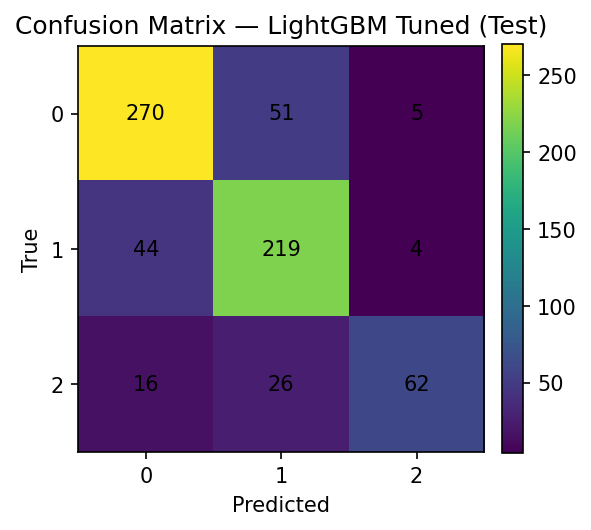

In [18]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — LightGBM Tuned (Test)")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lgbm_tuned_confusion_matrix.png"))
plt.show()

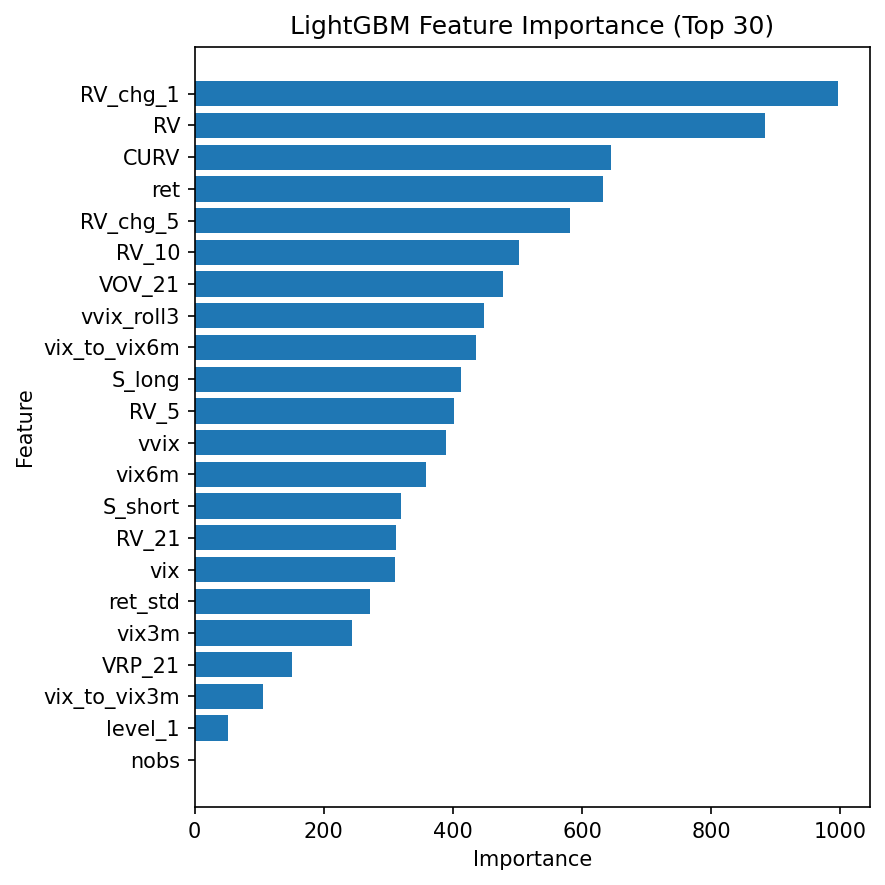


✅ Saved in /content/drive/MyDrive/Regime_pred/Models/LightGBM_Tuned:
 - lgbm_tuned_metrics.json
 - lgbm_tuned_test_predictions.csv
 - lgbm_tuned_confusion_matrix.png
 - lgbm_tuned_feature_importance.png
 - lgbm_tuned_model.txt
 - lgbm_tuned_features.json
 - lgbm_tuned_params.json


In [19]:
try:
    fi = best_model.feature_importances_
    order = np.argsort(fi)[::-1][:30]
    fig, ax = plt.subplots(figsize=(6,6), dpi=150)
    ax.barh(np.array(X.columns)[order][::-1], np.array(fi)[order][::-1])
    ax.set_title("LightGBM Feature Importance (Top 30)")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "lgbm_tuned_feature_importance.png"))
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)

# save model + feature list + params
best_model.booster_.save_model(os.path.join(OUT_DIR, "lgbm_tuned_model.txt"))
with open(os.path.join(OUT_DIR, "lgbm_tuned_features.json"), "w") as f:
    json.dump(list(X.columns), f, indent=2)
with open(os.path.join(OUT_DIR, "lgbm_tuned_params.json"), "w") as f:
    json.dump(best["params"], f, indent=2)

print(f"\n✅ Saved in {OUT_DIR}:")
print(" - lgbm_tuned_metrics.json")
print(" - lgbm_tuned_test_predictions.csv")
print(" - lgbm_tuned_confusion_matrix.png")
print(" - lgbm_tuned_feature_importance.png")
print(" - lgbm_tuned_model.txt")
print(" - lgbm_tuned_features.json")
print(" - lgbm_tuned_params.json")